# Init

## Imports

In [964]:
import numpy as np
import scipy.special
import os
import sys
import math
import matplotlib.pyplot as plt
import time
import tqdm
import torch

# from scipy.special import erfc
# from scipy.stats import uniform

_IPYTHON_PATH = os.path.expanduser("~/.ipython/")
_MY_PKG_PATHS = [_IPYTHON_PATH]
for my_pkg_path in _MY_PKG_PATHS:
    my_pkg_paths = [my_pkg_path, os.path.expanduser(my_pkg_path)]
    my_pkg_paths.append(os.path.realpath(my_pkg_paths[-1]))
    if all(x not in sys.path for x in my_pkg_paths):
        sys.path.append(my_pkg_paths[-1])
import my.utils as mu

## GPU memory

In [8]:
import re
import gc

def del_models():
    """Delete the previous models."""
    models_var_names = {'opt_problem'}
    for key in models_var_names:
        if key in globals():
            del globals()[key]
            
def del_jupyter_output():
    """Delete all global variables matching r'^_[0-9]*$' and keys of 'Out'.

    These names are typically used for output cells in jupyter-lab.
    This function followed by gc.collect() helps to free up memory
    or other resources occupied by unused vars.
    
    Usually, this duplicates the work of '%reset out', hence no
    additional variables are expected to be freed this way.
    If for some reason the magic '%reset out' is not working,
    this function could be used as an alternative.
    """
    globals_keys = list(globals().keys())
    for key in globals_keys:
        if re.match(r'^_[0-9]*$', key):
            del globals()[key]
    if 'Out' in globals_keys:
        out_keys = list(globals()['Out'].keys())
        for key in out_keys:
            del globals()['Out'][key]

def free_gpu_memory(delete_models=False):
    if delete_models:
        del_models()
    del_jupyter_output()
    gc.collect()

In [9]:
print(torch.cuda.memory_allocated(0) / 1024**3)
free_gpu_memory()
print(torch.cuda.memory_allocated(0) / 1024**3)

0.0
0.0


## Zero temperature GinOE

### Code

In [10]:
def ginoe_ypotential(ys):
    """
    Compute the function $-2 y^2 - ln(erfc(\sqrt{2} y))$ for y >= 0.
    
    We use direct formula (using scipy) for y <= 5 and a 2-point Pade approximant for y > 5.
    """
    ys = np.array(ys)
    # Initialize output array with the same shape as ys
    output = np.empty_like(ys, dtype=np.float64)
    
    # For y > 5 (the absolute error is under $2 * 10^{-13}$ for y > 4):
    mask1 = ys > 5
    ys1 = ys[mask1]
    y2 = ys1**2
    y4 = y2 * y2
    y6 = y4 * y2
    y8 = y4 * y4
    
    numerator = (-0.8904519590478536430137744382884281115310 - 
                 9.869261681191832701731724404616295971553/y6 - 
                 16.90359050157721106889984300899829825369/y4 - 
                 7.423694049765192486628066963007045221308/y2)
    
    denominator = (1.000000000000000000000000000000000000000 +
                   2.174258030977644555812272331973294792748/y8 +
                   15.74732873975124317572963943709831902318/y6 +
                   21.22717377517984141370472593958542366059/y4 +
                   8.617751886323607565086681753902613859088/y2)
                  
    result1 = 0.8904519590478536430137744382884281115310 + numerator / denominator - \
              np.log(0.3989422804014326779399460599343818684759 / ys1)
    
    output[mask1] = result1
    
    # For y <= 5 (should work for y <= 18)
    mask2 = ~mask1
    ys2 = ys[mask2]
    result2 = -2 * ys2**2 - np.log(scipy.special.erfc(np.sqrt(2) * ys2))
    
    output[mask2] = result2
    
    return output

def ginoe_potentials(density0, density1, xs, ys, dx):
    k = np.sum(density0)
    k1 = np.sum(density1)
    xs1 = xs[:, np.newaxis]
    assert ys[0] == 0
    ys1 = ys[np.newaxis, 1:]
    nx = len(xs)
    ny0 = len(ys)
    ny1 = len(ys1[0])
    
    J = 2 * k1 + k
    dk_ln_coeff = 0 # - math.log(2) / 2 - scipy.special.digamma(k + 1) + scipy.special.digamma((J-k)/2 + 1) / 2
    potential0 = xs**2 /  2
    potential1 = xs1**2 / 2 + ys1**2 / 2 + ginoe_ypotential(ys1) / 2
    
    interaction_00 = -np.sum(density0[np.newaxis, :] * np.log(np.maximum(dx, np.abs(xs[:, np.newaxis] - xs[np.newaxis, :]))), axis=1)
    interaction_01 = -np.sum(density1[np.newaxis, :, :] * np.log((xs[:, np.newaxis, np.newaxis] - xs1[np.newaxis, :, :])**2 + ys1[np.newaxis, :, :]**2), axis=(1, 2))
    interaction_10 = -np.sum(density0[np.newaxis, np.newaxis, :] * np.log((xs1[:, :, np.newaxis] - xs[np.newaxis, np.newaxis, :])**2 + ys1[:, :, np.newaxis]**2), axis=2) / 2
    dx1_2 = (xs1[:, :, np.newaxis, np.newaxis] - xs1[np.newaxis, np.newaxis, :, :])**2
    interaction_11 = -np.sum(density1[np.newaxis, np.newaxis, :, :] * (
            np.log(np.maximum(dx**2, dx1_2 + (ys1[:, :, np.newaxis, np.newaxis] - ys1[np.newaxis, np.newaxis, :, :])**2))
            + np.log(dx1_2 + (ys1[:, :, np.newaxis, np.newaxis] + ys1[np.newaxis, np.newaxis, :, :])**2)
        ) / 2, axis=(2, 3))
    assert interaction_11.shape == density1.shape
    
    potential0 = dk_ln_coeff * (k / J - 1) + potential0 + interaction_00 + interaction_01
    potential1 = dk_ln_coeff * k / J + potential1 + interaction_10 + interaction_11
    
    return potential0, potential1

In [11]:
class GinOEOptimizationProblem:
    def __init__(self, xs, ys, J):
        self.xs = xs
        self.ys = ys
        self.J = J
        self.learning_rate = 1.0
        dx = min((xs[-1] - xs[0]) / (xs.shape[0] - 1), (ys[-1] - ys[0]) / (ys.shape[0] - 1))
        
        xs1 = xs[:, np.newaxis]
        ys1 = ys[np.newaxis, 1:]
        nx = xs.shape[0]
        ny = ys.shape[0]
        ny1 = ys.shape[0] - 1
        potential0 = xs**2 /  2
        potential1 = xs1**2 / 2 + ys1**2 / 2 + ginoe_ypotential(ys1) / 2
        assert potential1.shape == (nx, ny1)
        potential1_flat = potential1.reshape(nx * ny1)
        self.potential_flat = np.concatenate([potential0, potential1_flat])
        assert self.potential_flat.shape == (nx * ny,)
        
        coupling_00 = -np.log(np.maximum(dx / (2 * np.exp(1)), np.abs(xs[:, np.newaxis] - xs[np.newaxis, :])))
        coupling_01 = -np.log((xs[:, np.newaxis, np.newaxis] - xs1[np.newaxis, :, :])**2 + ys1[np.newaxis, :, :]**2) / 2
        dx1_2 = (xs1[:, :, np.newaxis, np.newaxis] - xs1[np.newaxis, np.newaxis, :, :])**2
        coupling_11 = (
                - np.log(np.maximum((dx / 2)**2 / np.exp(1), dx1_2 + (ys1[:, :, np.newaxis, np.newaxis] - ys1[np.newaxis, np.newaxis, :, :])**2))
                - np.log(dx1_2 + (ys1[:, :, np.newaxis, np.newaxis] + ys1[np.newaxis, np.newaxis, :, :])**2)
            ) / 4
        assert coupling_01.shape == (nx, nx, ny1)
        coupling_01_flat = coupling_01.reshape((nx, nx * ny1))
        assert coupling_11.shape == (nx, ny1, nx, ny1)
        coupling_11_flat = coupling_11.reshape((nx * ny1, nx * ny1))
        self.coupling_flat = np.block([[coupling_00, coupling_01_flat], [coupling_01_flat.T, coupling_11_flat]])
        assert self.coupling_flat.shape == (nx * ny, nx * ny)
    
    def flatten_density(self, density0, density1):
        nx = self.xs.shape[0]
        ny = self.ys.shape[0]
        ny1 = self.ys.shape[0] - 1
        assert density0.shape == (nx,)
        assert density1.shape == (nx, ny1)
        return np.concatenate([density0, density1.reshape(nx * ny1)])
    
    def unflatten_density(self, density_flat):
        nx = self.xs.shape[0]
        ny = self.ys.shape[0]
        ny1 = self.ys.shape[0] - 1
        assert density_flat.shape == (nx * ny,)
        density0 = density_flat[:nx]
        density1 = density_flat[nx:].reshape(nx, ny1)
        return density0, density1
    
    def get_energy_flat(self, density_flat):
        res = density_flat @ self.potential_flat + density_flat @ self.coupling_flat @ density_flat / 2
        return res
    
    @torch.no_grad()
    def optimize(self, density_flat, device=None, epochs=100, snapshot_every=10, snapshots=None):
        if device is None:
            device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        density_flat = torch.from_numpy(density_flat).to(device)
        potential_flat = torch.from_numpy(self.potential_flat).to(device)
        coupling_flat = torch.from_numpy(self.coupling_flat).to(device)
        get_objective = lambda x: (
            torch.dot(x, potential_flat)
            + torch.matmul(torch.matmul(x, coupling_flat), x) / 2)
        objective = get_objective(density_flat)
        grad_new = None
        lr_decayed = False
        for epoch in range(epochs):
            if grad_new is None:
                energy_grad = potential_flat + coupling_flat @ density_flat
                grad_new = energy_grad - torch.mean(energy_grad[density_flat > 0])
            
            grad_new = grad_new - torch.mean(grad_new[(density_flat > 0) | (grad_new <= 0)])
            print(f"[{torch.std(energy_grad[density_flat > 0]):.3g}, {objective:.3f}, {self.learning_rate:.3g}]", end="")
            
            new_density_flat = density_flat - self.learning_rate * grad_new
            new_density_flat[new_density_flat < 0] = 0
            new_density_flat *= self.J / torch.sum(new_density_flat)
            new_objective = get_objective(new_density_flat)
            if lr_decayed or new_objective <= objective:
                density_flat = new_density_flat
                objective = new_objective
                grad_new = None
                self.learning_rate *= 1.01
                lr_decayed = False
            else:
                self.learning_rate *= 0.5
                lr_decayed = True
            
            if snapshots is not None and epoch % snapshot_every == 0:
                snapshots.append(density_flat.data.cpu().numpy())
        print("")
        return density_flat.data.cpu().numpy()
    
    def get_energy(self, density0, density1):
        return self.get_energy_flat(self.flatten_density(density0, density1))

### Compute

In [12]:
nx = 129
ny = 129
J = 255
evals_scale = 1.6 * J**0.5
xs = np.linspace(0, evals_scale, nx)
ys = np.linspace(0, evals_scale, ny)
dx = (xs[-1] - xs[0]) / (len(xs) - 1)
all_ys = np.concatenate((-ys[::-1], ys[1:]))

avg_density = J / (nx * (2 * ny - 1))
circle_r = 1.25 * J**0.5
circle_r2 = circle_r**2
density_0 = (xs**2 <= circle_r2) * 1.0
density_1 = (xs[:, np.newaxis]**2 + ys[np.newaxis, 1:]**2 <= circle_r2) * 1.0
density_1[0, :] = 0.4 * (np.maximum(0, circle_r2 - ys[np.newaxis, 1:]**2)**0.5)
total = np.sum(density_0) + np.sum(density_1)
density_0 = density_0 / total * J
density_1 = density_1 / total * J
density_results = []

In [13]:
opt_problem = GinOEOptimizationProblem(xs=xs, ys=ys, J=J)
density_flat = opt_problem.flatten_density(density_0, density_1)

In [16]:
for i in range(20):
    print(f"{i}: {opt_problem.get_energy_flat(density_flat):.3f}")
    density_flat = opt_problem.optimize(density_flat, snapshots=density_results)

0: -60341.691
[0.00108, -60341.691, 0.00109][0.00108, -60341.691, 0.00111][0.00108, -60341.691, 0.00112][0.00108, -60341.691, 0.00113][0.00108, -60341.691, 0.00114][0.00108, -60341.691, 0.00115][0.00108, -60341.691, 0.00116][0.00107, -60341.691, 0.00117][0.00107, -60341.691, 0.00119][0.00107, -60341.691, 0.0012][0.00107, -60341.691, 0.00121][0.00107, -60341.691, 0.00122][0.00107, -60341.691, 0.00123][0.00107, -60341.691, 0.00125][0.00107, -60341.691, 0.00126][0.00107, -60341.691, 0.00127][0.00107, -60341.691, 0.00128][0.00106, -60341.691, 0.0013][0.00106, -60341.691, 0.00131][0.00106, -60341.691, 0.00132][0.00106, -60341.691, 0.00134][0.00106, -60341.691, 0.00135][0.00106, -60341.691, 0.00136][0.00106, -60341.691, 0.00138][0.00106, -60341.691, 0.00139][0.00105, -60341.691, 0.0014][0.00105, -60341.691, 0.00142][0.00105, -60341.691, 0.00143][0.00105, -60341.691, 0.00145][0.00105, -60341.691, 0.00146][0.00105, -60341.691, 0.00148][0.00105, -60341.692, 0.00149][0.00105, -60341.692, 0.00151

### Plot

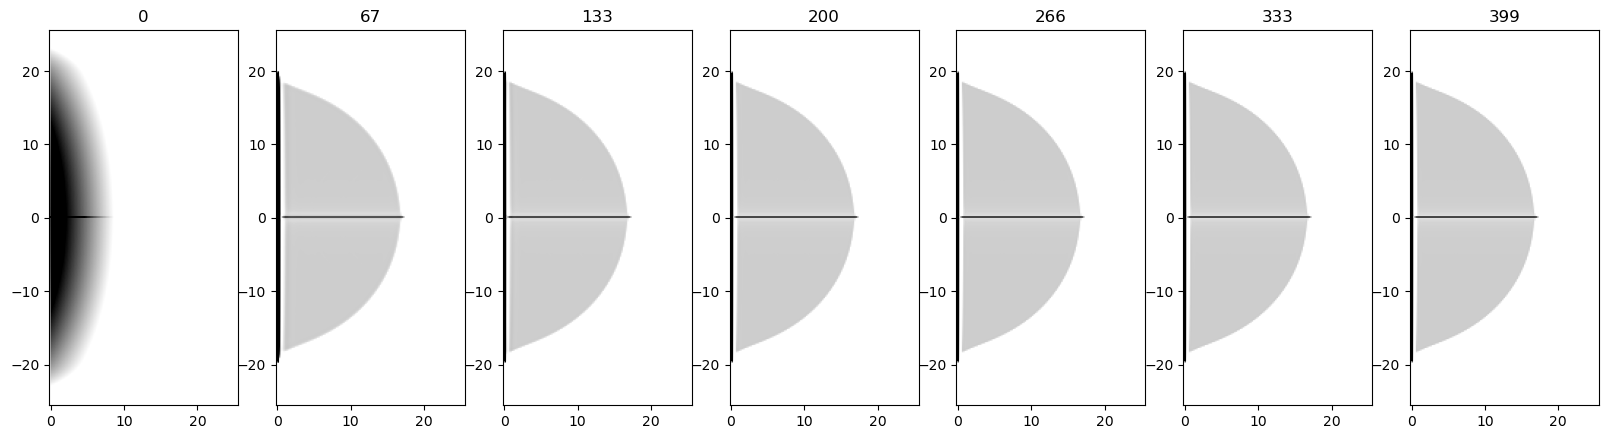

In [17]:
fig, axs = plt.subplots(ncols=7, figsize=(20, 5))
max_val = []
imax = len(axs)
imshow_lst = []
for i in range(imax):
    ax = axs[i]
    density_i = len(density_results) - 1 - (imax - i - 1) * (len(density_results) - 1) // (imax - 1)
    density0, density1 = opt_problem.unflatten_density(density_results[density_i])
    density = np.hstack([density1[:, ::-1] / 2, density0[:, np.newaxis], density1 / 2])
    assert density.shape == (xs.shape[0], all_ys.shape[0])
    imshow_lst.append(ax.imshow(np.vstack([np.zeros((1, density.shape[1])), density]).T, cmap='gray_r', origin='lower', extent=[2 * xs[0] - xs[1], xs[-1], all_ys[0], all_ys[-1]]))
    ax.set_title(density_i)
    max_val.append(density)
    
max_val = np.percentile(max_val, 99)
for c in imshow_lst:
    c.set_clim(0, max_val)

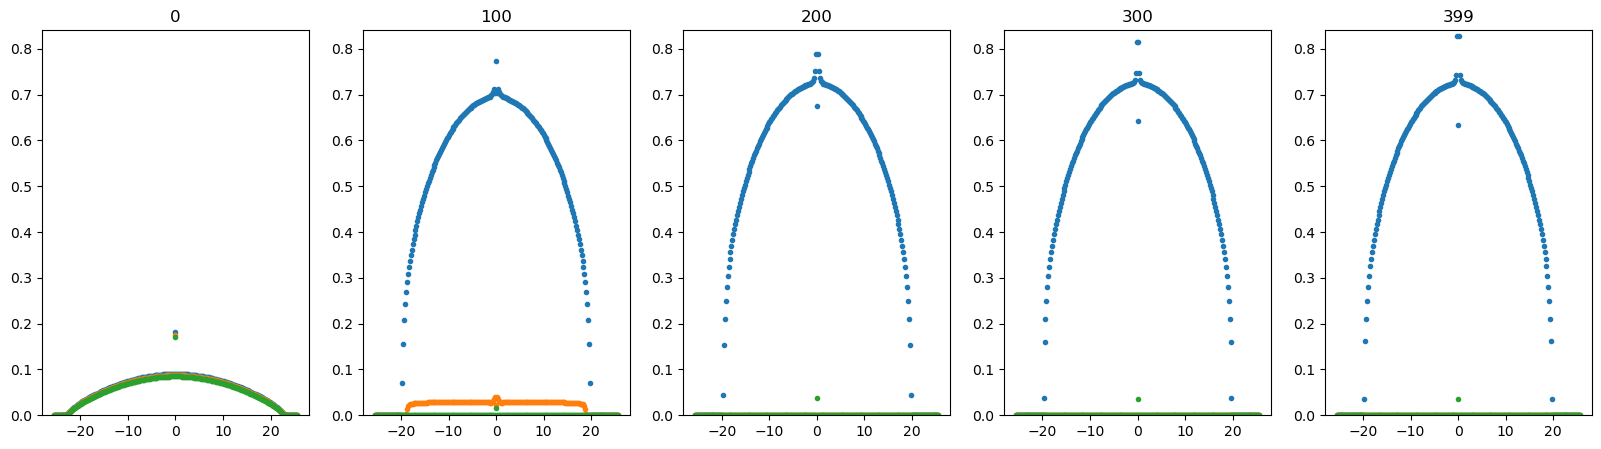

In [18]:
fig, axs = plt.subplots(ncols=5, figsize=(20, 5))
max_density = np.max(np.concatenate([d.flatten() for d in density_results]))
imax = len(axs)
max_val = 0
for i in range(imax):
    ax = axs[i]
    density_i = len(density_results) - 1 - (imax - i - 1) * (len(density_results) - 1) // (imax - 1)
    density0, density1 = opt_problem.unflatten_density(density_results[density_i])
    density = np.hstack([density1[:, ::-1] / 2, density0[:, np.newaxis], density1 / 2])
    ax.plot(all_ys, density[0, :], '.')
    ax.plot(all_ys, density[1, :], '.')
    ax.plot(all_ys, density[2, :], '.')
    ax.set_title(density_i)
    max_val = max(max_val, np.max(density[:3, :]))

for ax in axs:
    ax.set_ylim((0,1.016 * max_val))

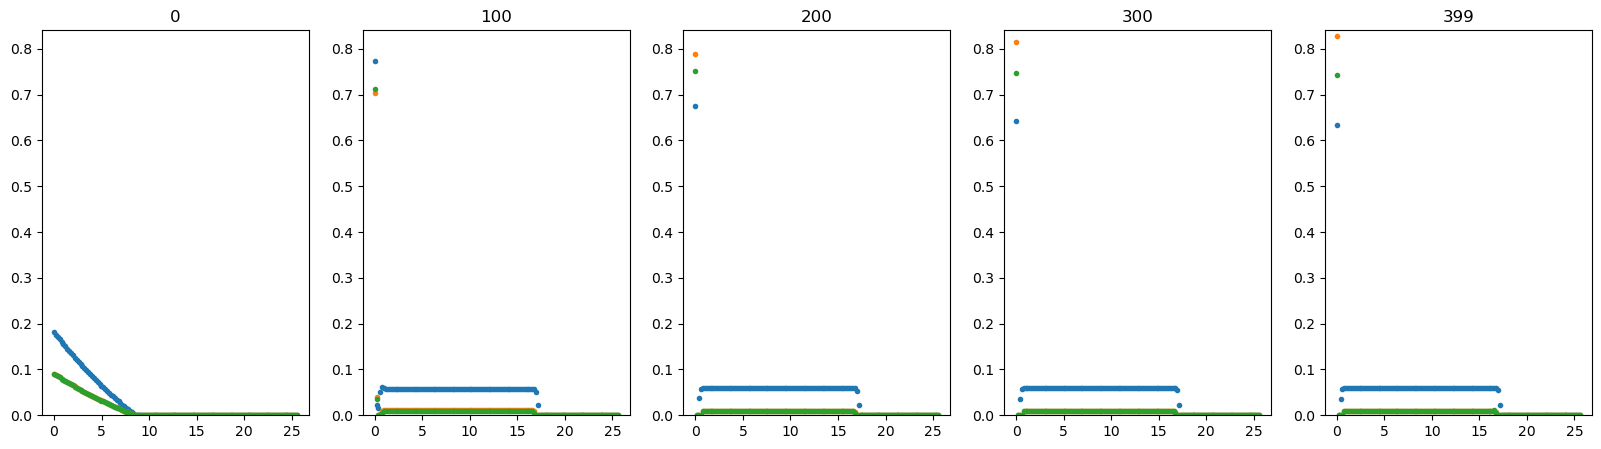

In [19]:
fig, axs = plt.subplots(ncols=5, figsize=(20, 5))
max_density = np.max(np.concatenate([d.flatten() for d in density_results]))
imax = len(axs)
max_val = 0
for i in range(imax):
    ax = axs[i]
    density_i = len(density_results) - 1 - (imax - i - 1) * (len(density_results) - 1) // (imax - 1)
    density0, density1 = opt_problem.unflatten_density(density_results[density_i])
    ax.plot(xs, density0[:], '.')
    ax.plot(xs, density1[:, 0] / 2, '.')
    ax.plot(xs, density1[:, 1] / 2, '.')
    ax.set_title(density_i)
    max_val = max(max_val, np.max(density0))
    max_val = max(max_val, np.max(density1[:, :2])/2)

for ax in axs:
    ax.set_ylim((0,1.016 * max_val))

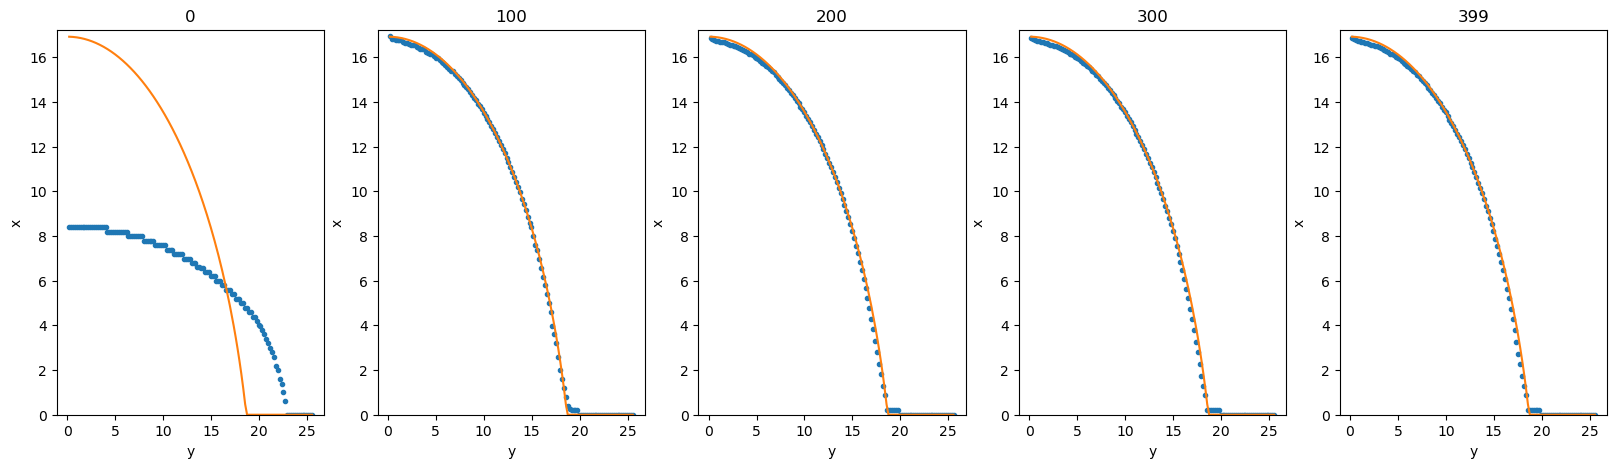

In [84]:
fig, axs = plt.subplots(ncols=5, figsize=(20, 5))
max_density = np.max(np.concatenate([d.flatten() for d in density_results]))
imax = len(axs)
max_val = 0
for i in range(imax):
    ax = axs[i]
    density_i = len(density_results) - 1 - (imax - i - 1) * (len(density_results) - 1) // (imax - 1)
    _, density1 = opt_problem.unflatten_density(density_results[density_i])
    median_density = np.median(density1[density1 > 0])
    density1_cs = np.cumsum(density1, axis=0)
    max_indices = np.argmax(density1_cs, axis=0)
    density1_boundary = xs[max_indices]
    dx = (xs[-1] - xs[0]) / (len(xs) - 1)
    density1_boundary += dx * np.minimum(1, density1[max_indices, np.arange(len(max_indices))] / median_density)
    ax.plot(ys[1:], density1_boundary, '.')
    top = 1.06 * J**0.5
    scale = 1.22
    right = 1.17 * J**0.5
    offset = (scale**2 * right**2 - top**2) / (2 * top)
    boundary_fit = np.maximum(0,(top + offset)**2 - (scale * ys[1:])**2)**0.5 - offset
    boundary_fit = np.maximum(0, boundary_fit)
    ax.plot(ys[1:], boundary_fit)
    ax.set_title(density_i)
    ax.set_ylabel('x')
    ax.set_xlabel('y')
    max_val = max(max_val, np.max(density1_boundary))

for ax in axs:
    ax.set_ylim((0,1.016 * max_val))

### Fit

In [139]:
median_density / (2 * dx**2) / (1 / math.pi)

0.9947429950785028

(0.0, 25.5499510762741)

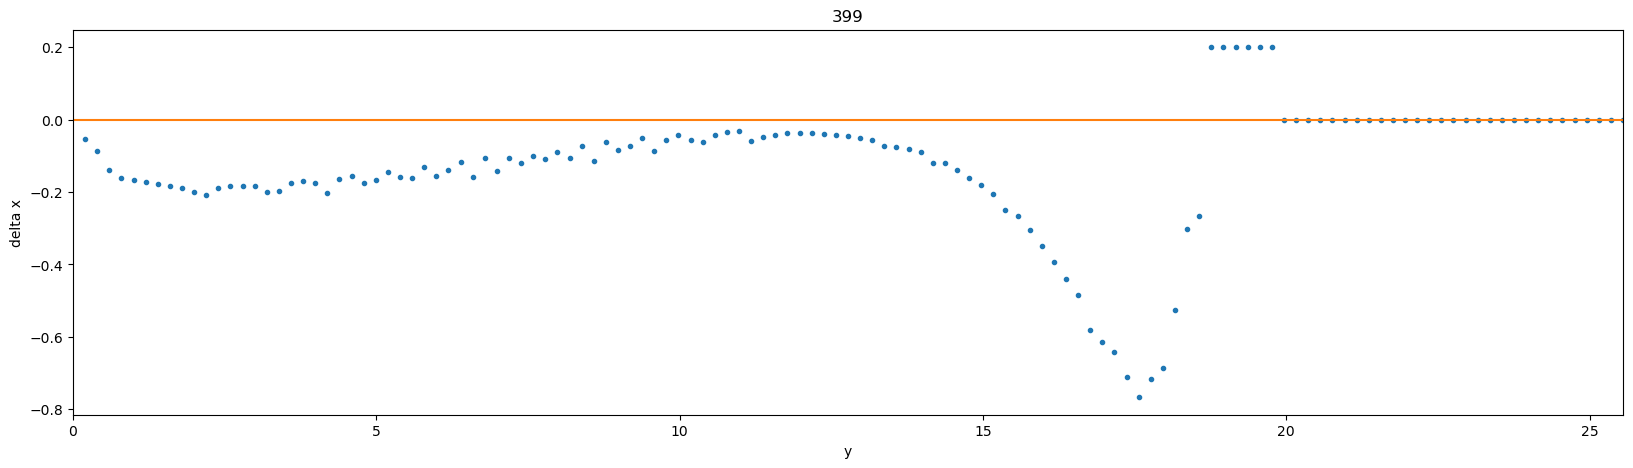

In [135]:
fig, ax = plt.subplots(figsize=(20, 5))
_, density1 = opt_problem.unflatten_density(density_results[-1])
median_density = np.median(density1[density1 > 0])
density1_cs = np.cumsum(density1, axis=0)
max_indices = np.argmax(density1_cs, axis=0)
density1_boundary = xs[max_indices]
dx = (xs[-1] - xs[0]) / (len(xs) - 1)
density1_boundary += dx * np.minimum(1, density1[max_indices, np.arange(len(max_indices))] / median_density)
top = 1.06 * J**0.5
scale = 1.22
right = 1.17 * J**0.5
offset = (scale**2 * right**2 - top**2) / (2 * top)
boundary_fit = np.maximum(0,(top + offset)**2 - (scale * ys[1:])**2)**0.5 - offset
boundary_fit = np.maximum(0, boundary_fit)
ax.plot(ys[1:], density1_boundary - boundary_fit, '.')
ax_ymax = ys[-1]*2 - ys[-1]
ax.plot([0, ax_ymax], np.zeros(2))
ax.set_title(density_i)
ax.set_ylabel('delta x')
ax.set_xlabel('y')
ax.set_xlim((0, ax_ymax))

In [138]:
J0 = J
J = 3
top = 1.06 * J**0.5
scale = 1.22
right = 1.17 * J**0.5
offset = (scale**2 * right**2 - top**2) / (2 * top)
print(offset)
J = J0

0.7466370697507463


In [91]:
# Median density in the bulk is approximately 1 / pi:
print(f"{median_density / dx**2 / 2 * math.pi:.3f}")

0.995


Text(0.5, 0, 'y')

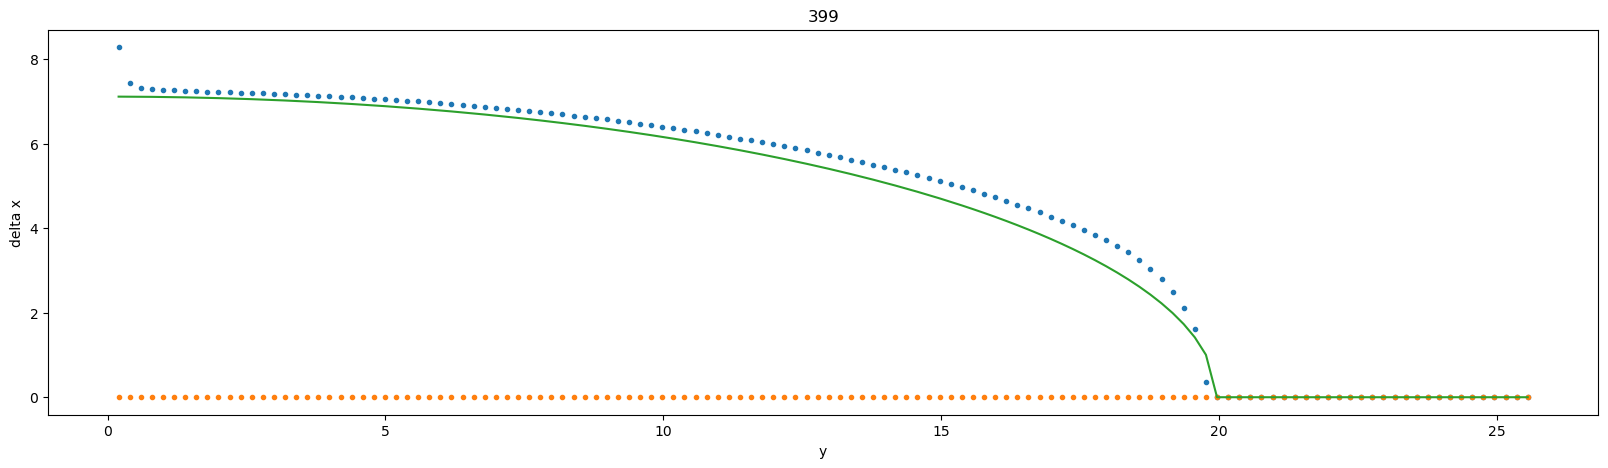

In [147]:
fig, ax = plt.subplots(figsize=(20, 5))
density0, density1 = opt_problem.unflatten_density(density_results[-1])
ax.plot(ys[1:], density1[0, :] / dx, '.')
ax.plot(ys[1:], density1[1, :] / dx, '.')

top = 1.4 * J**0.5 / math.pi
scale = top / right
right = 1.25 * J**0.5
offset = (scale**2 * right**2 - top**2) / (2 * top)
y_charge_fit = np.maximum(0,(top + offset)**2 - (scale * ys[1:])**2)**0.5 - offset
y_charge_fit = np.maximum(0, y_charge_fit)
ax.plot(ys[1:], y_charge_fit)

ax.set_title(density_i)
ax.set_ylabel('delta x')
ax.set_xlabel('y')

In [154]:
{**None}

TypeError: 'NoneType' object is not a mapping

In [152]:
(np.sum(density1[0, :5]) - 5 * density1[0, 5]) / (1 - 2 * math.exp(-1))

0.9800638973959295

In [122]:
density0[0] / (2 / math.pi)

0.9938938790077979

Text(0.5, 0, 'x')

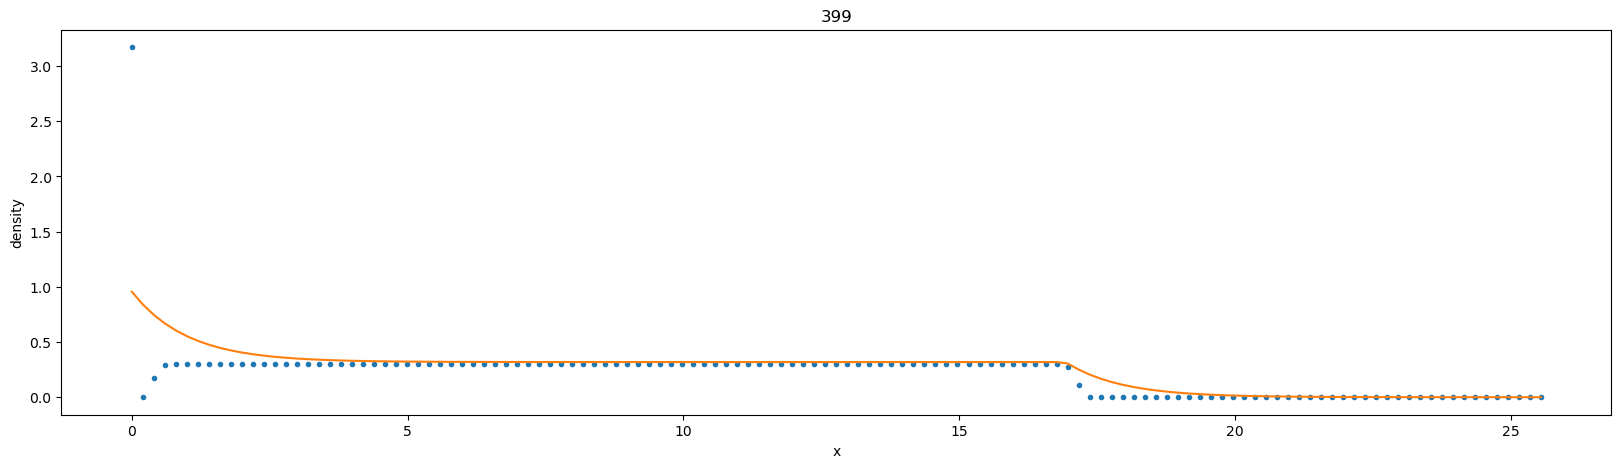

In [128]:
fig, ax = plt.subplots(figsize=(20, 5))
density0, density1 = opt_problem.unflatten_density(density_results[-1])
ax.plot(xs, density0 / dx, '.')

top = 1 / math.pi
right = 1.06 * J**0.5
zero_charge = 2 / math.pi
x_charge_fit = top * np.exp(-np.maximum(0, xs - right)) + zero_charge * np.exp(-xs)
ax.plot(xs, x_charge_fit)

ax.set_title(density_i)
ax.set_ylabel('density')
ax.set_xlabel('x')

In [97]:
np.sum(density0) / J

0.022238887202981186

In [99]:
np.sum(density1[1:, :]) / J

0.5203790150750273

In [101]:
np.sum(density1[0, :]) / J

0.45738209772199184

In [62]:
right = (top**2 + 2 * top * offset)**0.5 / scale / J**0.5
offset = (scale**2 * right**2 - top**2) / (2 * top)
(offset, offset1)

(2.7244696742907646, 2.7244696742907615)

In [63]:
(top**2 + 2 * top * offset)**0.5 / scale / J**0.5

1.1590595383095876

## MCMC

In [735]:
import datetime

In [738]:
def is_posd(a):
    try:
        scipy.linalg.cholesky(a, lower=True)
        return True
    except np.linalg.LinAlgError:
        return False
    
def is_a_posd(mcmc_state, rng):
    real_evals = np.array(mcmc_state.real_evals, dtype=np.float64)
    complex_evals = ginoe_mcmc.GinOEStableMCMC._np_array(mcmc_state.complex_evals, 'C')
    G, c = ginoe_mcmc.GSampler.sample_Gc(real_evals, complex_evals, rng)
    a = sgm.gc_to_a(G, c)
    a_c0 = sgm.gc_to_a(G, c * 0)
    return is_posd(a), is_posd(a_c0)

In [751]:
importlib.reload(ginoe_mcmc)
a_stats = {}
mcmc_stats = {}
def mcmc_callback(state, rng):
    cur_a_stats = a_stats.get(state.J, None)
    if cur_a_stats is None:
        cur_a_stats = []
        a_stats[state.J] = cur_a_stats
    cur_a_stats.append(is_a_posd(state, rng))

for d in range(2, 4):
    print(f"{datetime.datetime.now():%y-%m-%d %H:%M:%S}: {d=}")
    J = d**2 - 1
    sgm = ginoe_mcmc.SparseGellMann(d=d)

    mcmc = ginoe_mcmc.GinOEStableMCMC(J=J, seed=44)
    cur_mcmc_stats = {}
    mcmc_stats[J] = cur_mcmc_stats
    cur_mcmc_stats["burn_in"] = mcmc.run(n_epochs=40)
    cur_mcmc_stats["compute"] = mcmc.run(n_epochs=500000, callback=mcmc_callback)
print(f"{datetime.datetime.now():%y-%m-%d %H:%M:%S}")

23-09-05 14:10:48: d=2
0
0.........1.........2.........3.........4.........5.........6.........7.........8.........9.........0.........1.........2.........3.........4.........5.........6.........7.........8.........9.........0.........1.........2.........3.........4.........5.........6.........7.........8.........9.........0.........1.........2.........3.........4.........5.........6.........7.........8.........9.........0.........1.........2.........3.........4.........5.........6.........7.........8.........9.........0.........1.........2.........3.........4.........5.........6.........7.........8.........9.........0.........1.........2.........3.........4.........5.........6.........7.........8.........9.........0.........1.........2.........3.........4.........5.........6.........7.........8.........9.........0.........1.........2.........3.........4.........5.........6.........7.........8.........9.........0.........1.........2.........3.........4.........5.........6.........7....

In [762]:
a_stats = {k: np.array(v) for k, v in a_stats.items()}

In [763]:
[np.sum(a_stats[2**2-1], axis=0), a_stats[2**2-1].shape]

[array([ 2220, 17729]), (1000000, 2)]

In [926]:
for k in [0, 2220, 17729]:
    lb, ub = ginoe_mcmc.wilson_interval(1000000, k)
    mu = (lb + ub) / 2
    print(f"{k: 7d}: {lb:.6f} {mu:.6f} {ub:.6f}")

      0: 0.000000 0.000002 0.000004
   2220: 0.002129 0.002222 0.002315
  17729: 0.017472 0.017731 0.017990


In [765]:
ginoe_mcmc.wilson_interval(1000000, 2220)

(0.0021291605654800245, 0.002314693224288863)

In [768]:
ginoe_mcmc.wilson_interval(1000000, 0)

(9.088566293361466e-08, 4.7893920079154094e-06)

In [817]:
ginoe_mcmc.wilson_interval(10**6, 0)

(array(0.), array(3.68887265e-06))

In [845]:
ginoe_mcmc.wilson_interval(10**6, 0.9496 * 10**6)

(array(0.9491708), array(0.95002939))

In [855]:
np.mean(np.array(res_w) < 0.95)

0.0

In [798]:
[ginoe_mcmc.wilson_interval(10**6, 0), (0, 1 - 0.05**(10**-6))]

[(array(0.), array(4.78939201e-06)), (0, 2.9957277863923437e-06)]

In [ ]:
ginoe_mcmc.wilson_interval(10**6, 17729)

In [757]:
np.mean(ginoe_mcmc.wilson_interval(10**6, 17729))

0.017730886742512747

In [754]:
np.sum(a_stats[3**2-1], axis=0)

array([0, 0])

In [747]:
np.mean(a_stats[2**2-1], axis=0)

array([0.0021 , 0.01769])

In [749]:
a_stats[2**2-1].shape

(100000, 2)

In [750]:
p = 0.01769
n = 10000
z = 1.96
p - z * (p * (1-p) / n)**0.5

0.01510628699971843

In [700]:
400 * sum(d**2 - 1 for d in range(2, 14))

322400

In [706]:
s = "".join(str(a[1]+0) for a in a_stats[3])
print(f"{len(s)}: {s}")

800: 00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000010000000000000000000000000000100000000000000000000000000000000000000000000000001000000000000000000000000000000000000000000000000000000000000000000000000000100000000000000000000000000000000000000000000001100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001000000000000000000000


In [690]:
mcmc_state = mcmc.state
real_evals = np.array(mcmc_state.real_evals, dtype=np.float64)
complex_evals = ginoe_mcmc.GinOEStableMCMC._np_array(mcmc_state.complex_evals, 'C')
G, c = ginoe_mcmc.GSampler.sample_Gc(real_evals, complex_evals, rng)
a = sgm.gc_to_a(G, c)
a_c0 = sgm.gc_to_a(G, c * 0)

In [694]:
np.linalg.eigvals(G).real < 0

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [628]:
%%timeit -n 10
a = sgm.gc_to_a(G, c)

756 ms ± 2.09 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [663]:
ts = []

In [660]:
importlib.reload(ginoe_mcmc)
sgm = ginoe_mcmc.SparseGellMann(d=d)

In [664]:
for _ in range(10):
    t0 = time.time()
    res = (
        sgm.times_F(G)
       + c[:, np.newaxis, np.newaxis] * np.eye(d)[np.newaxis, :, :]) # (i, a, b)
    t1 = time.time()
    res = sgm.times_newF(res) # (i, a, m, c)
    t2 = time.time()
    res = np.moveaxis(res, 0, 3) # (a, m, c, i)
    t3 = time.time()
    res = sgm.times_F(res) # (a, m, c, c, d)
    t4 = time.time()
    res = np.einsum('amccd->mad', res)
    t5 = time.time()
    res = sgm.times_newF(res)
    t6 = time.time()
    res = np.einsum('mana->mn', res)
    t7 = time.time()
    ts.append([t0, t1, t2, t3, t4, t5, t6, t7])
    assert np.allclose(res, a)

In [665]:
dts = np.diff(ts, axis=1)
for i in range(dts.shape[1]):
    mu = np.mean(dts[:, i])
    std = np.std(dts[:, i])
    print(f"{i}: {mu:.3f}s +/- {std:.3f}s")

0: 0.003s +/- 0.002s
1: 0.155s +/- 0.005s
2: 0.000s +/- 0.000s
3: 0.414s +/- 0.003s
4: 0.018s +/- 0.000s
5: 0.137s +/- 0.003s
6: 0.028s +/- 0.001s


In [644]:
a = res

## Tests

### MCMC

In [283]:
mcmc_seed = 1
stats = []

In [343]:
import ginoe_mcmc
import importlib
importlib.reload(ginoe_mcmc)

<module 'ginoe_mcmc' from '/home/victor/Dropbox (Lidar group)/qc4ml_work/ode2qme/ode2qme/ginoe_mcmc.py'>

In [326]:
print(f"seed: {mcmc_seed}")
mcmc = ginoe_mcmc.GinOEStableMCMC(J=255, seed=mcmc_seed)
cur_stats = mcmc.run(n_epochs=41)
cur_stats['evals'] = (mcmc.state.real_evals, mcmc.state.complex_evals)
stats.append(cur_stats)

seed: 356
[0: 0.469][1: 0.289][2: 0.203][3: 0.188][4: 0.180][5: 0.148][6: 0.109][7: 0.086][8: 0.070][9: 0.148][10: 0.055][11: 0.125][12: 0.109][13: 0.109][14: 0.109][15: 0.109][16: 0.109][17: 0.141][18: 0.078][19: 0.125][20: 0.102][21: 0.086][22: 0.117][23: 0.078][24: 0.117][25: 0.078][26: 0.102][27: 0.102][28: 0.102][29: 0.047][30: 0.094][31: 0.062][32: 0.031][33: 0.078][34: 0.062][35: 0.055][36: 0.047][37: 0.133][38: 0.117][39: 0.094][40: 0.148]


In [341]:
max([s['seed'] for s in stats])

456

In [342]:
mcmc_seed = 456

In [344]:
for _ in range(100):
    mcmc_seed += 1
    print(f"seed: {mcmc_seed}")
    mcmc = ginoe_mcmc.GinOEStableMCMC(J=3, seed=mcmc_seed)
    cur_stats = mcmc.run(n_epochs=41)
    cur_stats['evals'] = (mcmc.state.real_evals, mcmc.state.complex_evals)
    stats.append(cur_stats)

seed: 457
[0: 0.500][1: 0.500][2: 1.000][3: 0.500][4: 0.500][5: 0.000][6: 0.500][7: 0.500][8: 1.000][9: 0.500][10: 0.250][11: 0.500][12: 1.000][13: 0.000][14: 0.000][15: 0.500][16: 0.500][17: 0.500][18: 0.000][19: 1.000][20: 0.500][21: 0.000][22: 0.250][23: 0.500][24: 0.500][25: 0.000][26: 0.500][27: 0.000][28: 0.000][29: 0.000][30: 0.000][31: 0.500][32: 0.250][33: 0.000][34: 0.500][35: 1.000][36: 0.500][37: 0.500][38: 0.500][39: 0.500][40: 0.500]
seed: 458
[0: 1.000][1: 0.500][2: 0.500][3: 0.000][4: 0.500][5: 0.000][6: 0.500][7: 0.500][8: 0.500][9: 0.500][10: 0.500][11: 1.000][12: 0.000][13: 1.000][14: 1.000][15: 1.000][16: 0.500][17: 0.500][18: 0.500][19: 1.000][20: 0.500][21: 0.000][22: 1.000][23: 1.000][24: 0.500][25: 0.250][26: 1.000][27: 1.000][28: 0.500][29: 0.500][30: 1.000][31: 0.500][32: 0.000][33: 0.500][34: 0.500][35: 0.500][36: 0.500][37: 0.500][38: 0.500][39: 1.000][40: 0.000]
seed: 459
[0: 0.500][1: 0.500][2: 0.500][3: 0.500][4: 0.500][5: 0.000][6: 0.500][7: 0.500][8: 0.

In [345]:
ars = np.array([s["acceptance_rate"] for s in stats if "J" in s and s["J"] == 3])

In [347]:
ars

array([[0.5, 0.5, 1. , ..., 0.5, 0.5, 0.5],
       [1. , 0.5, 0.5, ..., 0.5, 1. , 0. ],
       [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
       ...,
       [0.5, 0.5, 0.5, ..., 0.5, 0. , 0.5],
       [1. , 0. , 1. , ..., 1. , 0.5, 0.5],
       [0. , 1. , 1. , ..., 0. , 1. , 0.5]])

(0.0, 0.688)

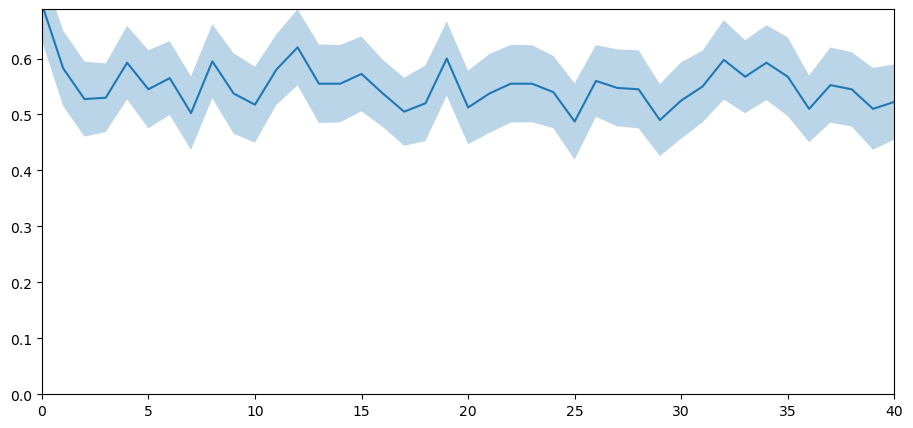

In [349]:
fig, ax = plt.subplots(ncols=1, figsize=(11, 5))
xs = np.arange(ars.shape[1])
ars_mu = np.mean(ars, axis=0)
ars_ste = np.std(ars, axis=0) / ars.shape[0]**0.5
ax.plot(xs, ars_mu)
ax.fill_between(xs, ars_mu - 2 * ars_ste, ars_mu + 2 * ars_ste, alpha=0.3)
ax.set_xlim((0, len(ars_mu) - 1))
ax.set_ylim((0, max(ars_mu[10:] + 2 * ars_ste[10:])))

In [330]:
for i in (20, 40):
    print(f"{i}: ({ars_mu[i] - 2 * ars_ste[i]}, {ars_mu[i] + 2 * ars_ste[i]}")

20: (0.08212458442026874, 0.08929085675620185
40: (0.07746568159654081, 0.08495553689085415


In [353]:
evals = []
for s in stats:
    if s.get("epoch_range", (None, -1))[1] < 40 or s.get("J", 0) != 3:
        continue
    real_evals, complex_evals = s["evals"]
    evals.append([(r, 0) for r in real_evals])
    evals.append(complex_evals)
evals = [vi for v in evals for vi in v]
evals = np.array(evals)

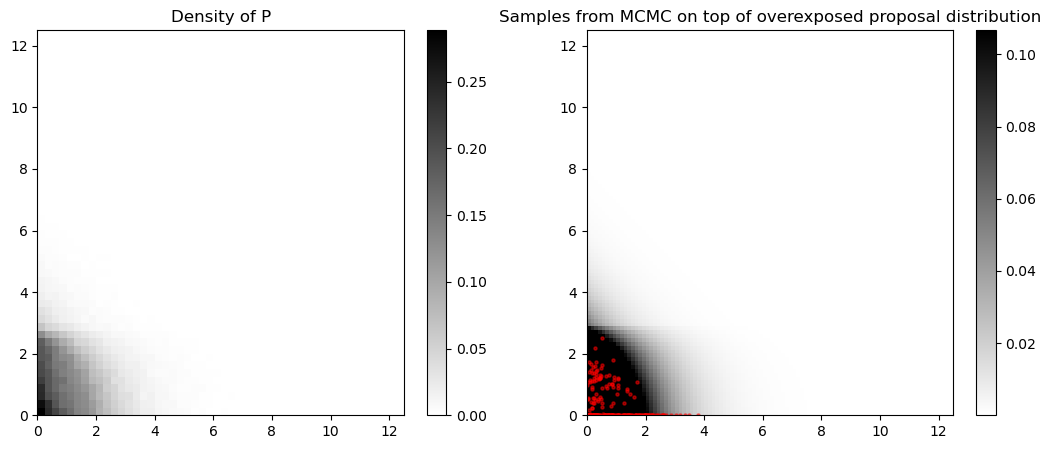

In [358]:
J = 3
pp = ginoe_mcmc.GinOEStablePairProposal(J=J)

# Define or import your sample_p and pdf_q functions here
# For demonstration, I'll use a 2D Gaussian distribution for both
def sample_p():
    return pp._complex_model.sample(rng)

def pdf_q(x, y):
    return pp._complex_model.get_pdf(x, y)

# Sampling from P
n_samples = 100000
samples_p = np.array([sample_p() for _ in range(n_samples)])

# Get vmax for plotting region
vmax = 1.01 * np.max(samples_p)

# Plotting
fig, (ax_p, ax_q) = plt.subplots(ncols=2, figsize=(13, 5))

# Plot 2D histogram for P
h = ax_p.hist2d(samples_p[:, 0], samples_p[:, 1], bins=50, range=[[0, vmax], [0, vmax]], density=True, cmap='gray_r')
plt.colorbar(h[3], ax=ax_p)
ax_p.set_title('Density of P')

# Plot density for Q
x, y = np.meshgrid(np.linspace(0, vmax, 100), np.linspace(0, vmax, 100))
z = np.array([pdf_q(x_, y_) for x_, y_ in zip(np.ravel(x), np.ravel(y))])
z = np.minimum(0.5 / (1.25 * J**0.5)**2 , z.reshape(x.shape))
im = ax_q.imshow(z, extent=[0, vmax, 0, vmax], origin='lower', aspect='auto', cmap='gray_r')
plt.colorbar(im, ax=ax_q)
ax_q.set_title('Samples from MCMC on top of overexposed proposal distribution')
ax_q.scatter(evals[:, 0], evals[:, 1], c='red', marker='o', s=5, alpha=0.5)

plt.show()

### Proposal

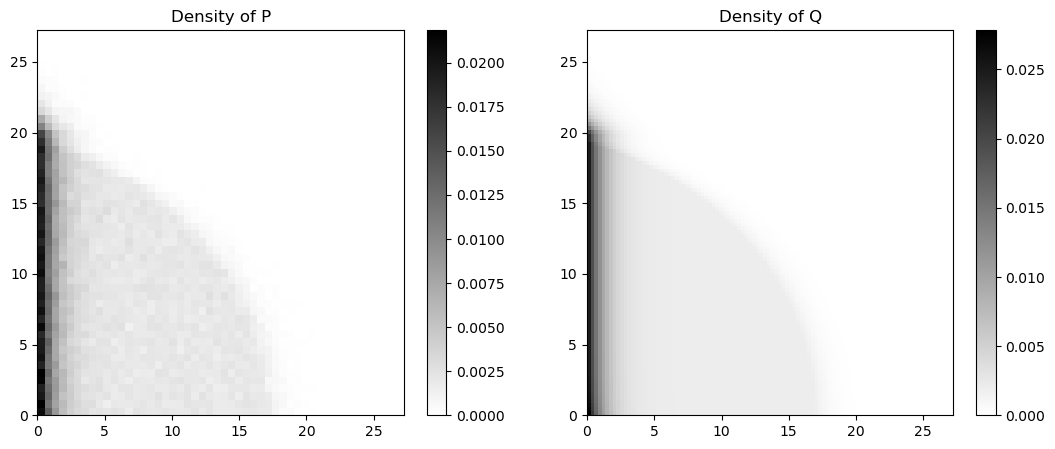

In [311]:
pp = ginoe_mcmc.GinOEStablePairProposal(J=255)

# Define or import your sample_p and pdf_q functions here
# For demonstration, I'll use a 2D Gaussian distribution for both
def sample_p():
    return pp._complex_model.sample(rng)

def pdf_q(x, y):
    return pp._complex_model.get_pdf(x, y)

# Sampling from P
n_samples = 100000
samples_p = np.array([sample_p() for _ in range(n_samples)])

# Get vmax for plotting region
vmax = 1.01 * np.max(samples_p)

# Plotting
fig, (ax_p, ax_q) = plt.subplots(ncols=2, figsize=(13, 5))

# Plot 2D histogram for P
h = ax_p.hist2d(samples_p[:, 0], samples_p[:, 1], bins=50, range=[[0, vmax], [0, vmax]], density=True, cmap='gray_r')
plt.colorbar(h[3], ax=ax_p)
ax_p.set_title('Density of P')

# Plot density for Q
x, y = np.meshgrid(np.linspace(0, vmax, 100), np.linspace(0, vmax, 100))
z = np.array([pdf_q(x_, y_) for x_, y_ in zip(np.ravel(x), np.ravel(y))])
z = z.reshape(x.shape)
im = ax_q.imshow(z, extent=[0, vmax, 0, vmax], origin='lower', aspect='auto', cmap='gray_r')
plt.colorbar(im, ax=ax_q)
ax_q.set_title('Density of Q')

plt.show()

### Truncated normal sampling

In [408]:
importlib.reload(ginoe_mcmc)
xs = ginoe_mcmc.GSampler.truncated_normal_sample(threshold=np.full(fill_value=5, shape=40000, dtype=np.float64), rng=rng)

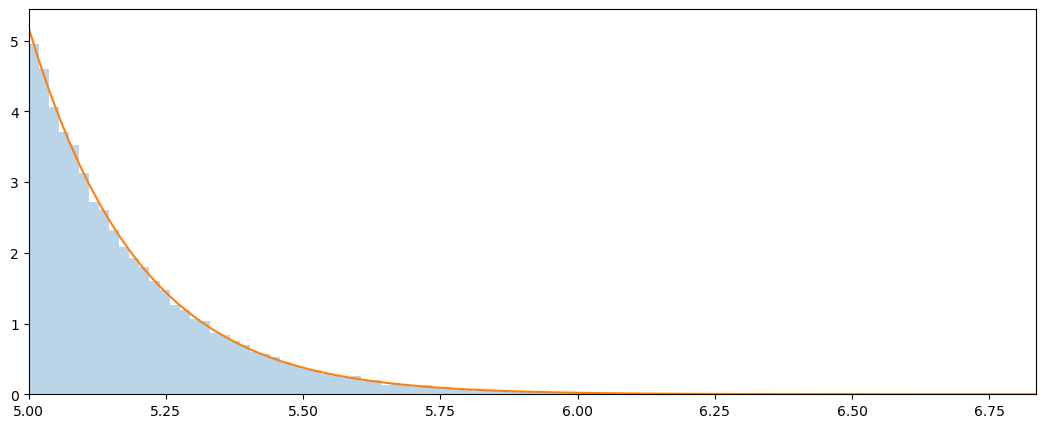

In [409]:
fig, ax = plt.subplots(ncols=1, figsize=(13, 5))
xmin = 5
xmax = max(xs)
ax.hist(xs, range=(xmin, xmax), bins=100, alpha=0.3, density=True)
ax.set_xlim(xmin, xmax)
xvals = np.linspace(xmin, xmax, 101)
yvals = (2/math.pi)**0.5 * np.exp(-xvals**2/2) / scipy.special.erfc(xmin / 2**0.5)
ax.plot(xvals, yvals)

### Conversions

In [578]:
importlib.reload(ginoe_mcmc)
d = 2
J = d**2 - 1
G = rng.normal(size=(J, J))
c = rng.normal(size=J)
sgm = ginoe_mcmc.SparseGellMann(d)

In [513]:
G1 = np.zeros(shape=(3, 3), dtype=np.float64)
G1[1, 2] = 1.0
a = sgm.gc_to_a(G1, c * 0)
a[0, 0]

-0.5j

In [514]:
eye1 = np.eye(3)[1]
eye2 = np.eye(3)[2]
res1 = sgm.times_F(G1)
res1_expected = eye1[:, np.newaxis, np.newaxis] * sigma_matrices[2]
np.allclose(res1, res1_expected)

True

In [515]:
res2 = sgm.times_newF(res1)
res2_expected = eye1[:, None, None, None] * np.moveaxis([sigma_matrices[2] @ sigma_matrices[m] for m in range(3)], 0, 1)[None, ...]
np.allclose(res2, res2_expected)

True

In [516]:
res3 = np.moveaxis(res2, 0, 3) # a, m, c, i
res3_expected = np.moveaxis([sigma_matrices[2] @ sigma_matrices[m] for m in range(3)], 0, 1)[..., None] * eye1[None, None, None, :]
np.allclose(res3, res3_expected)

True

In [580]:
res4 = sgm.times_F(res3) # (a, m, c, c, d)
res4_expected = np.moveaxis([sigma_matrices[2] @ sigma_matrices[m] for m in range(3)], 0, 1)[..., None, None] * sigma_matrices[1][None, None, None, ...]
res4_v2 = sum(res3[:, :, :, i, None, None] * sigma_matrices[i][None, None, None, :, :] for i in range(3))
[np.allclose(res4, res4_expected), np.allclose(res4_v2, res4_expected), np.allclose(res4, res4_v2)]

[True, True, True]

In [586]:
x = np.zeros(shape=(2, 3, 2, 3), dtype=np.complex128)
x[0, 0, 1, 1] = 1j
y = sgm.times_F(x)
y_expected = sum(x[:, :, :, i, None, None] * sigma_matrices[i][None, None, None, :, :] for i in range(3))
np.allclose(y, y_expected)

True

In [504]:
res5 = np.einsum('amccd->mad', res4)
res5_expected = np.array([sigma_matrices[0] @ sigma_matrices[m] @ sigma_matrices[0] for m in range(3)])
np.allclose(res5, res5_expected)

True

In [505]:
res6 = sgm.times_newF(res5)
res6_expected = np.moveaxis([[sigma_matrices[0] @ sigma_matrices[m] @ sigma_matrices[0] @ sigma_matrices[n] for n in range(3)] for m in range(3)], 1, 2)
np.allclose(res6, res6_expected)

True

In [506]:
np.einsum('mana->mn', res6

array([[[[ 0.25+0.j  , -0.  +0.j  ],
         [ 0.  +0.j  ,  0.25+0.j  ],
         [ 0.  +0.j  ,  0.  -0.25j]],

        [[ 0.  +0.j  ,  0.25-0.j  ],
         [-0.25+0.j  ,  0.  +0.j  ],
         [-0.  -0.25j,  0.  -0.j  ]]],


       [[[ 0.  +0.j  ,  0.25-0.j  ],
         [-0.25+0.j  ,  0.  +0.j  ],
         [-0.  -0.25j,  0.  -0.j  ]],

        [[-0.25+0.j  , -0.  +0.j  ],
         [ 0.  +0.j  , -0.25+0.j  ],
         [ 0.  +0.j  ,  0.  +0.25j]]],


       [[[ 0.  +0.j  , -0.  -0.25j],
         [ 0.  +0.25j,  0.  +0.j  ],
         [-0.25+0.j  ,  0.  -0.j  ]],

        [[ 0.  -0.25j, -0.  +0.j  ],
         [ 0.  +0.j  ,  0.  -0.25j],
         [ 0.  +0.j  , -0.25+0.j  ]]]])

In [582]:
%%time
a = sgm.gc_to_a(G, c * 0)
H = sgm.gc_to_h(G, c)
G1 = sgm.ah_to_g(a, H)

CPU times: user 6.21 ms, sys: 2.35 ms, total: 8.57 ms
Wall time: 5.81 ms


In [583]:
np.allclose(a, a.T.conj())

True

In [584]:
np.allclose(H, H.T.conj())

True

In [585]:
np.allclose(G, G1)

True

### Binomial CI

In [919]:
def ci_gpt3_f(n, k):
    alpha = 0.05
    p_hat = k / n
    q1 = (1 - alpha) / 2
    q2 = 1 - q1
    lower_endpoint = scipy.stats.beta.ppf(q1, k, n - k + 1)
    upper_endpoint = scipy.stats.beta.ppf(q2, k + 1, n - k)

    return lower_endpoint, upper_endpoint

def ci_gpt4_f(n, x, alpha=0.05):
    """
    Calculate exact binomial confidence interval.
    
    Parameters:
    n (int): Number of trials
    x (int): Number of successes
    alpha (float): Significance level
    
    Returns:
    tuple: Lower and upper confidence limits
    """
    
    def lower_func(c):
        return scipy.special.betainc(x, n - x + 1, c) - alpha / 2
    
    def upper_func(c):
        return 1 - scipy.special.betainc(x + 1, n - x, c) - alpha / 2
    
    # Initial guesses for lower and upper bounds
    lower_guess = x / n
    upper_guess = x / n
    
    # Bisect to find lower and upper confidence bounds
    lower_bound = scipy.optimize.bisect(lower_func, 0, lower_guess)
    upper_bound = scipy.optimize.bisect(upper_func, upper_guess, 1)
    
    return lower_bound, upper_bound

def ci_gpt4_f_lb(n, x, alpha=0.05):
    lower_bound = scipy.special.betaincinv(x, n - x + 1, alpha / 2)
    return np.nan_to_num(lower_bound, nan=0)

def ci_gpt4_f_v2(n, x, alpha=0.05):
    lower_bound = ci_gpt4_f_lb(n, x, alpha)
    upper_bound = 1 - ci_gpt4_f_lb(n, n - x, alpha)
    return lower_bound, upper_bound

def add_ci_test(p, samples, ci_lookup, results):
    try:
        lb, ub = tuple(c[samples] for c in ci_lookup)
    except:
        print(f"{type(ci_lookup)} {type(ci_lookup[0])}")
        raise
    results.append(np.mean((lb < p) & (p < ub)))

In [864]:
n_trials = 10**6
ci_wilson = ginoe_mcmc.wilson_interval(n_trials, np.arange(n_trials + 1))
ci_gpt = ci_gpt3_f(n_trials, np.arange(n_trials + 1))
ci_gpt = np.nan_to_num(ci_gpt[0], nan=0), np.nan_to_num(ci_gpt[1], nan=1)
ci_gpt4 = [ci_gpt4_f(n_trials, k) for k in np.arange(n_trials + 1)]
ci_gpt4 = np.array(ci_gpt4).T
ci_gpt4_v2 = ci_gpt4_f_v2(n_trials, np.arange(n_trials + 1))
ci_gpt4_v2 = np.nan_to_num(ci_gpt4_v2[0], nan=0), np.nan_to_num(ci_gpt4_v2[1], nan=1)

In [917]:
n_samples = 10**6
pmin = 36e-7
pmax = 38e-7
ps = np.linspace(pmin, pmax, 101)
# ps = ps[np.minimum(res_gpt4, res_wilson) < 0.951]
res_wilson = []
res_gpt = []
res_gpt4 = []
for p in ps:
    samples = rng.binomial(n=n_trials, p=p, size=n_samples)
    add_ci_test(p, samples, ci_wilson, res_wilson)
    add_ci_test(p, samples, ci_gpt, res_gpt)
    add_ci_test(p, samples, ci_gpt4, res_gpt4)

(0.939483, 0.9887688499999999)

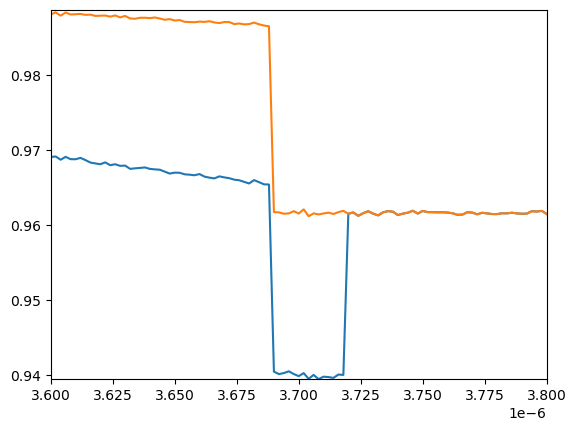

In [918]:
fig, ax = plt.subplots()
ax.plot(ps, res_wilson)
# ax.plot(ps, res_gpt)
ax.plot(ps, res_gpt4)
ax.set_xlim((pmin, pmax))
ymin = np.min([res_wilson, res_gpt4])
if ymin < 0.1:
    ymin = 0
ymax = 0.95 + 1.01 * (np.max([res_wilson, res_gpt4]) - 0.95)
if ymax > 0.99:
    ymax = 1
ax.set_ylim((ymin, ymax))

In [965]:
mu.print_dir(scipy.stats.poisson.ppf)

a, b, badvalue, cdf, entropy, expect, extradoc, freeze, generic_moment, inc, interval, isf, logcdf, logpmf, logsf,
mean, median, moment, moment_tol, name, nnlf, numargs, pmf, ppf, random_state, rvs, sf, shapes, stats, std, support,
var, vecentropy


In [966]:
?scipy.stats.poisson.ppf

Signature: scipy.stats.poisson.ppf(q, *args, **kwds)
Docstring:
Percent point function (inverse of `cdf`) at q of the given RV.

Parameters
----------
q : array_like
    Lower tail probability.
arg1, arg2, arg3,... : array_like
    The shape parameter(s) for the distribution (see docstring of the
    instance object for more information).
loc : array_like, optional
    Location parameter (default=0).

Returns
-------
k : array_like
    Quantile corresponding to the lower tail probability, q.
File:      ~/.local/lib/mambaforge/envs/bitchifc_minimal/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py
Type:      method

In [987]:
x_min = 0.16
x0 = 0.7755
x_max = 2.27
k = 3
alpha = 0.05
lower_bound = 0.5 * scipy.stats.chi2.ppf(alpha / 2, 2 * k) * x0 / k
upper_bound = 0.5 * scipy.stats.chi2.ppf(1 - alpha / 2, 2 * k + 2) * x0 / k
print(",".join(f"{v:.3f}" for v in [lower_bound, upper_bound]))

0.160,2.266


In [982]:
[0.5 * scipy.stats.chi2.ppf(alpha / 2, 200), 0.5 * scipy.stats.chi2.ppf(1 - alpha / 2, 200 + 2)]

[81.36399125092314, 121.62679379242638]

In [977]:
mu.print_dir(scipy.stats.gamma)

a, b, badvalue, cdf, entropy, expect, extradoc, fit, fit_loc_scale, freeze, generic_moment, interval, isf, logcdf,
logpdf, logsf, mean, median, moment, moment_type, name, nnlf, numargs, pdf, ppf, random_state, rvs, sf, shapes, stats,
std, support, var, vecentropy, xtol
